# Music Generator
## COMP 432 Fall 2020
## Natalia Whiteley 40044353
## Michael Naccache 29794840

In [2]:
# these libraries are included with python
import os
from collections import Counter

# all of these libraries must be installed with pip
from music21 import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf

Here are some constants used to define some hyperparameters for the model.

The **TRAIN_GENRE** constant defines the genre used for the training data for the model. It can be any of the genres listed in **GENRES** above it. The best genres for training were Zelda and the original genres, as they import fairly fast and give the best results.

The **TIMESTEPS** is used to create the X dataset. **TIMESTEPS** is the number of notes used to predict the next note in the model. We've found that lower values around 8-16 tend to give the best results in terms of note variation in the music created.

**SONG_LENGTH** is the number of notes in the final song made by the model. 20 notes is about 10 seconds, and is enough to analyze the results. Longer songs tend to be more repetitive.

In [3]:
VERBOSE = True
GENRES = ['sample', 'classical', ' blues', 'poprock', 'original', 'jazz', 'country', 'zelda', 'animalcrossing']
TRAIN_GENRE = 'classical'
PALETTE = 'husl'
TIMESTEPS = 8
SONG_LENGTH = 20

## Part 1: Import Dataset

Here we define some helper functions for loading files and parsing the midi format. Then, we load the midi files and thier genres.
The format we use to import the midi files is a list of every song, where each song is a dictionary of a track for each instrument. Each instrument track is a list of all the notes in the track.

ex. all_songs -> jazz_song_1 -> piano track -> A5, G2, B5, ...

The midi parser and importer can be slow when used on longer songs, so training data is limited to only 1 genre for now.

In [4]:
# given the name of a midi file, returns a 2D array of notes per instrument
def import_midi(midi_file, verbose=VERBOSE):

    # parse midi file
    midi = converter.parse(midi_file)
  
    # seperate based on instrument
    midi_parts = instrument.partitionByInstrument(midi)

    notes = {}
    notes_to_parse = []

    for part in midi_parts.parts:
        notes[part.getInstrument().__class__] = []
        notes_to_parse = part.recurse()

        # finding whether a particular element is note or a chord
        for element in notes_to_parse: 
            #note
            if isinstance(element, note.Note):
                notes[part.getInstrument().__class__].append(str(element.pitch))
            
            #chord
            elif isinstance(element, chord.Chord):
                notes[part.getInstrument().__class__].append('.'.join(str(n.pitch) for n in element))

    # remove any empty instruments
    notes = {k: np.array(v) for k, v in notes.items() if v}

    if verbose:
        print('Finished importing {}.'.format(midi_file))

    return notes

# gets the path and label for every file in a directory and its sub-directories
def get_all_files_in_dir(dir_path, verbose=VERBOSE):
    midis = []
    genres = []

    for root, dirs, files in os.walk(dir_path):
        genre = os.path.basename(root)

        # if genre not in list, ignore it
        if genre in GENRES:
            # load all midi files in this directory
            for file in files:
                if file.endswith('.mid'):
                    midis.append(os.path.join(root, file))
                    genres.append(genre)
            
            if verbose:
                print('Loaded all {} midi files.'.format(genre))

    return midis, genres


In [5]:
midi_filenames, genres = get_all_files_in_dir('./midi_files')
songs = [import_midi(x) for x in midi_filenames if genres[midi_filenames.index(x)] == TRAIN_GENRE]

# some video game songs have unknown instruments that can't import
songs = [song for song in songs if song != {}]

Loaded all zelda midi files.
Loaded all original midi files.
Loaded all poprock midi files.
Loaded all animalcrossing midi files.
Loaded all classical midi files.
Loaded all sample midi files.
Loaded all country midi files.
Loaded all jazz midi files.
Finished importing ./midi_files/classical/aeris_theme_mi2.mid.
Finished importing ./midi_files/classical/rondo_alla_turca-1783-Mozart_jpp.mid.
Finished importing ./midi_files/classical/sonata_in_C-Paganini_bz3.mid.
Finished importing ./midi_files/classical/sonata_cello_bass-Vivaldi_del.mid.
Finished importing ./midi_files/classical/calling_rondo_sn.mid.
Finished importing ./midi_files/classical/like_to_the_damask_rose-kar_gf.mid.
Finished importing ./midi_files/classical/fanfare_for_the_common_man-ACopeland_mbrt.mid.
Finished importing ./midi_files/classical/i_gloria_in_excelsis_deo-Vivaldi_rb.mid.
Finished importing ./midi_files/classical/if_winter_comes_1922-kar_jpp.mid.
Finished importing ./midi_files/classical/into_the_night-Clara-Edw

## Part 2: Data Analysis
Here we make some graphs for the distribution of genres and distributions of notes in each song to see what, if any, adjustements we need to make to the data.

From the genre distribution, jazz leads by a significant margin, meaning it would get the best results from training, but Zelda, original, and country were mostly used for the training as they are quicker to import.

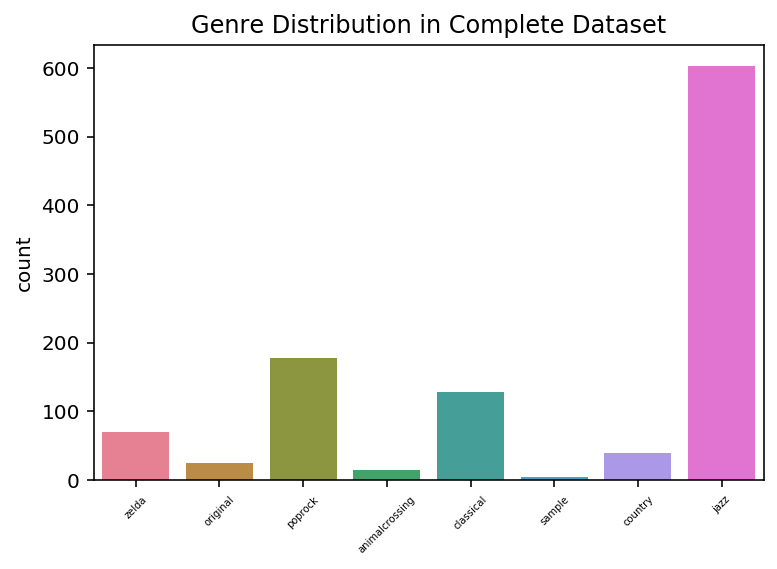

In [6]:
# graph distribution of genres
sns.countplot(genres, palette=PALETTE)
plt.title('Genre Distribution in Complete Dataset')
plt.tick_params(axis='x', labelsize=5, labelrotation=45)

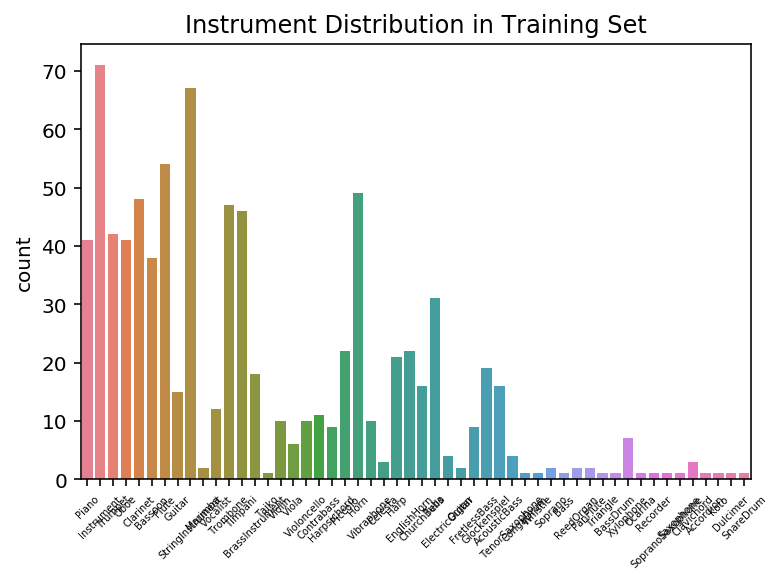

In [7]:
# graph instrument distribution in training data
instruments = []
for song in songs:
    for instrument in song.keys():
        instruments.append(str(instrument).split('.')[2][:-2])

sns.countplot(instruments, palette=PALETTE)
plt.title('Instrument Distribution in Training Set')
plt.tick_params(axis='x', labelsize=5, labelrotation=45)

In [8]:
# graph note distribution in one song
def plot_notes_per_instrument(song, song_name):
    fig, ax = plt.subplots(len(song.keys()), 1, figsize=(10, 10))
    fig.suptitle('Note distribution in by instrument {}'.format(song_name))
    
    i = 0
    for instrument in song.keys():        
        if len(song.keys()) == 1:
            sns.countplot(song[instrument], ax=ax, palette=PALETTE)
            ax.set_title(str(instrument).split('.')[2][:-2])
            ax.tick_params(axis='x', labelsize=5, labelrotation=45)
        else:  
            sns.countplot(song[instrument], ax=ax[i], palette=PALETTE)
            ax[i].set_title(str(instrument).split('.')[2][:-2])
            ax[i].tick_params(axis='x', labelsize=5, labelrotation=45)
            i += 1
    plt.subplots_adjust(hspace=1)

With the note distributions, you can see that some instruments, most notably the Piano, have an excess of notes played only a few times that don't add much to the general composition.

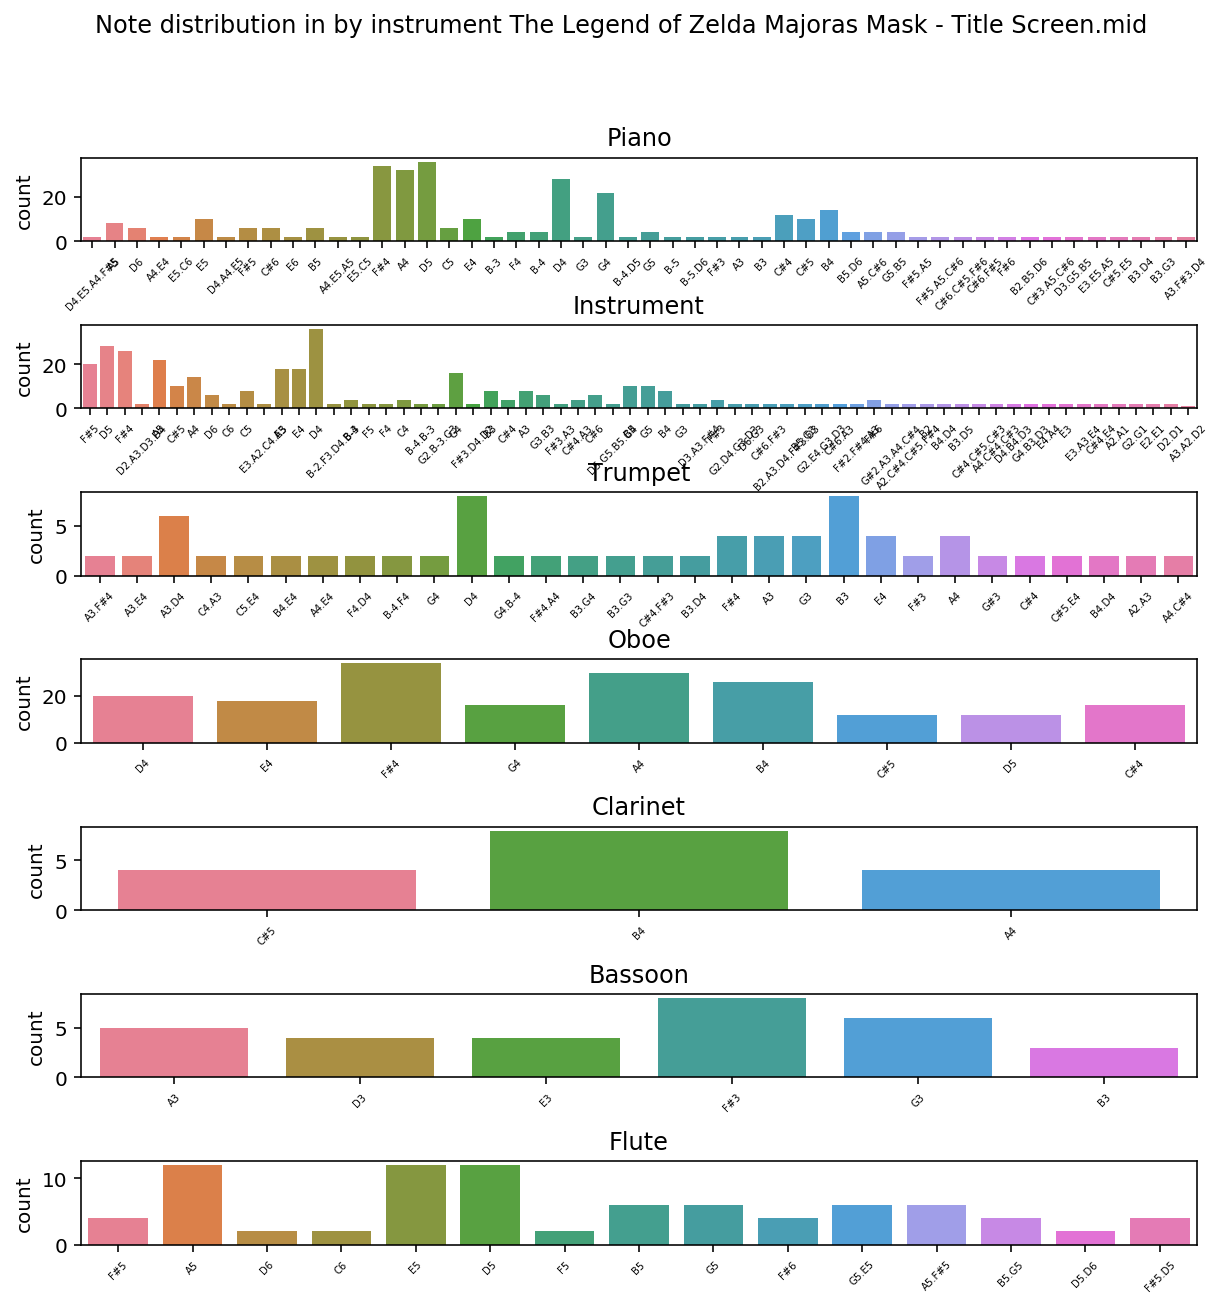

In [9]:
plot_notes_per_instrument(songs[0], os.path.basename(midi_filenames[0]))

## Part 3: Split and Normalize Dataset

We decided to remove the notes that were less than 5% of the frequency of the most frequent note. These notes are generally only played once or twice and would muddle the model's patterns.

In [12]:
# remove any unfrequent notes; ie. less than 10% of the max frequency
def remove_unfrequent_notes(song):
    # select each instrument track
    for instrument in song.keys():
        freq = Counter(song[instrument])

        # get the max feuquency of notes
        max_freq = freq.most_common(1)[0][1]

        # make list of all the significant notes
        frequent_notes = [note for note in song[instrument] if freq[note] >= max_freq * 0.05]
        new_song = []
        for note in song[instrument]:
            if note in frequent_notes:
                new_song.append(note)
        
        song[instrument] = new_song

    return song

# remove infrequent notes from songs
songs = [remove_unfrequent_notes(song) for song in songs]

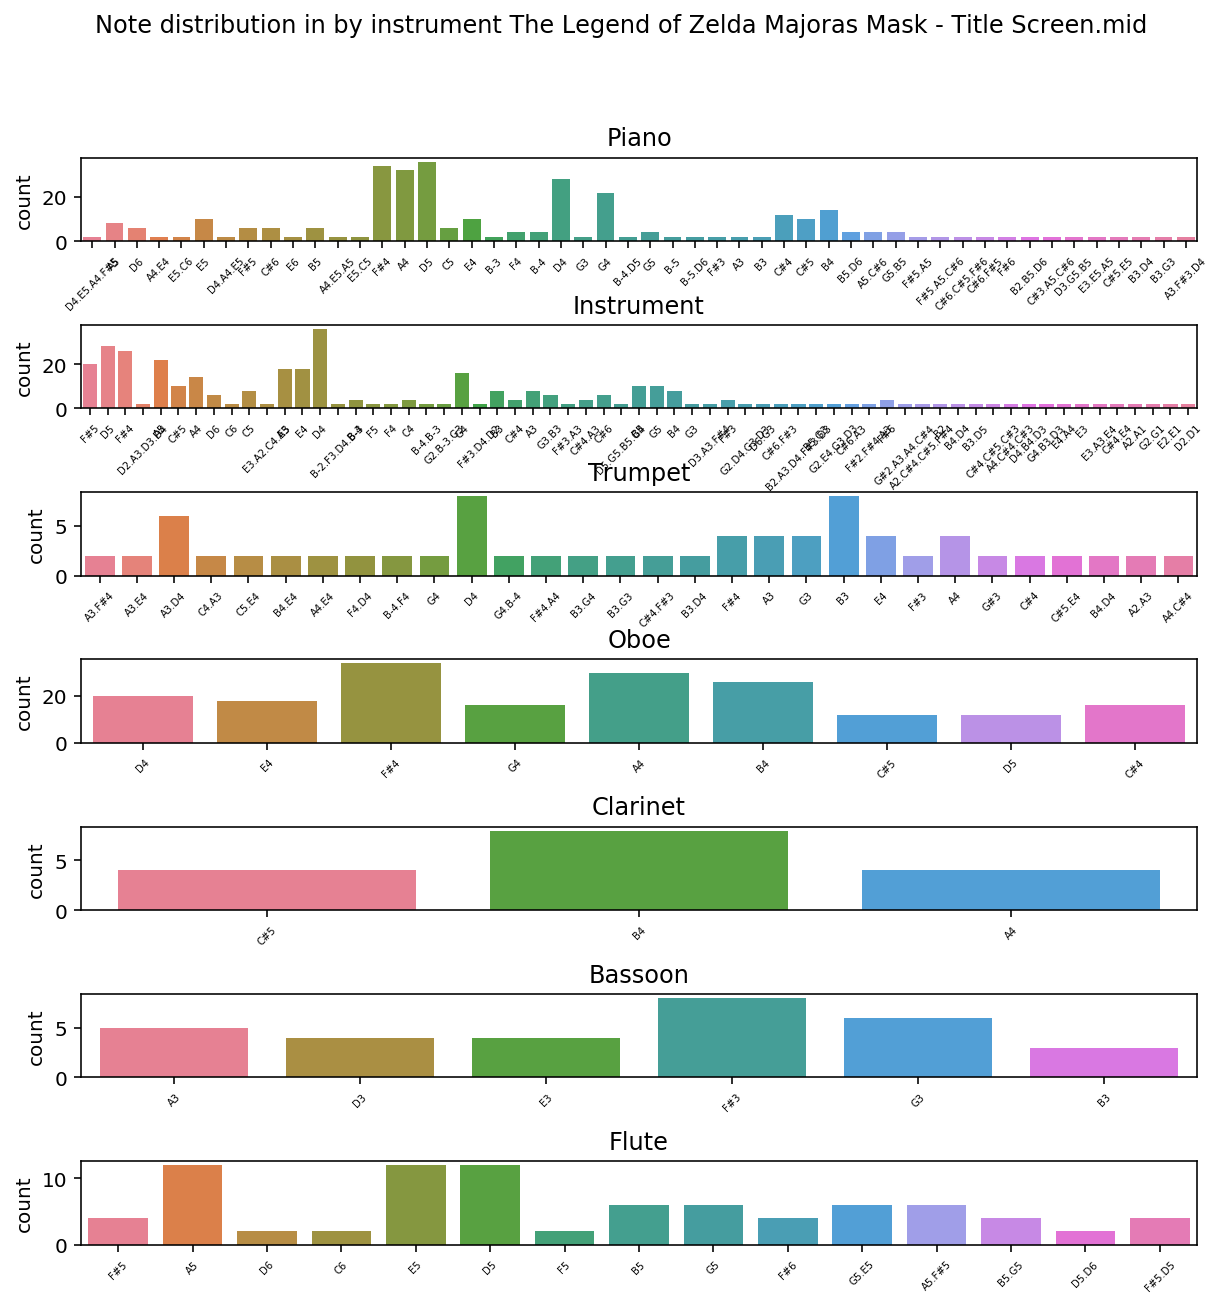

In [13]:
# regraph normalized notes
plot_notes_per_instrument(songs[0], os.path.basename(midi_filenames[0]))

This part encodes all the notes and chords as integers and creates 2 dictionaries to quickly convert back and forth.

In [14]:
# dictionaries to quickly convert between notes and ints and vice versa
note_to_int = {}
int_to_note = {}

def convert_song(song, reverse=False):
    new_song = []

    # reverse is translating ints back to note strings
    if reverse:
        for note in song:
            new_song.append(int_to_note[note])

    # translate note strings to ints
    else:
        for note in song:
            # note already in dictionary
            if note in note_to_int:
                new_song.append(note_to_int[note])
            # add note to both dictionaries
            else:
                note_to_int[note] = len(note_to_int)
                int_to_note[note_to_int[note]] = note
                new_song.append(note_to_int[note])

    return new_song

Here, we string together the notes from many songs in a genre to form one, long song to be used for training the model.

In [15]:
def combine_notes(combine_songs):
    long_song = {}
    for song in combine_songs:
        for instrument in song.keys():
            if instrument in long_song.keys():
                long_song[instrument] += song[instrument]
            else:
                long_song[instrument] = song[instrument]
        
    return long_song

In [16]:
# flatten songs so it contains all notes from a genre
train_song = combine_notes(songs)
train_song = {instrument : convert_song(train_song[instrument]) for instrument in train_song.keys()}

Create the X and y datasets. As this model is trying to predict the next note given a sequence of previous notes, X will be a slice of notes and y is the next note after the slice.

ex. song = [C3, D3, E3, C3] -> X = [C3, D3, E3] y = [C3]

In [17]:
def make_X_and_y(notes):
    X = []
    y = []

    for i in range(0, len(notes) - TIMESTEPS):
        notes_in = notes[i: i + TIMESTEPS]
        notes_out = notes[i + TIMESTEPS]
        
        X.append(notes_in)
        y.append(notes_out)

    return X, y

def get_train_and_val(X, y):
    # create X and y from int-encoded categories
    X = np.array(X)
    y = np.array(y)

    # split into train and validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    # convert train and val sets to tensors
    X_train = tf.convert_to_tensor(X_train)
    X_val = tf.convert_to_tensor(X_val)
    y_train = tf.convert_to_tensor(y_train)
    y_val = tf.convert_to_tensor(y_val)

    return X_train, X_val, y_train, y_val

Here we create the training and validation data for each instrument seperately.

In [18]:
X_train_all_instruments, X_val_all_instruments, y_train_all_instruments, y_val_all_instruments = {}, {}, {}, {}

for instrument in train_song.keys():
    X, y = make_X_and_y(train_song[instrument])
    X_train, X_val, y_train, y_val = get_train_and_val(X, y)

    X_train_all_instruments[instrument] = X_train
    X_val_all_instruments[instrument] = X_val
    y_train_all_instruments[instrument] = y_train
    y_val_all_instruments[instrument] = y_val

## Part 3: Train GAN With Wavenet

This is our attempt at a model similar to the WaveNet model created by Google Deepmind. The model features 3 layers of 1-dimensional, causal convolution with relu activation functions. The last layers are just Dense layers with tanh and softmax activation functions.

We found that the Stochastic Gradient Descent optimiizer had better results than the Adam optimizer in TensorFlow.

In [19]:
# wavenet-ish model
model = tf.keras.Sequential([
    # embedding layer, so that similar values have similar weights
    tf.keras.layers.Embedding(len(note_to_int), 100, input_length=TIMESTEPS ,trainable=True),
    # step 1: causal 1D convolution layer
    tf.keras.layers.Conv1D(TIMESTEPS * 2, 3, padding='causal', activation='relu'),
    tf.keras.layers.Dropout(0.2),

    # step 2: dialated 1D causal convolutional layer with sigmoid activation
    tf.keras.layers.Conv1D(TIMESTEPS * 4, 3, dilation_rate=2, padding='causal', activation='relu'),
    tf.keras.layers.Dropout(0.2),

    # step 3: dialated 2D causal convolutional layer with tanh activation
    tf.keras.layers.Conv1D(TIMESTEPS * 8, 3, dilation_rate=4, padding='causal', activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.GlobalMaxPool1D(),
    
    # reduce to output size
    tf.keras.layers.Dense(TIMESTEPS * 8, activation='tanh'),
    tf.keras.layers.Dense(len(note_to_int), activation='softmax')
])

# compile the model
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# pretty summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 100)            389100    
_________________________________________________________________
conv1d (Conv1D)              (None, 8, 16)             4816      
_________________________________________________________________
dropout (Dropout)            (None, 8, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 32)             1568      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 64)             6208      
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 64)             0

Now we actually train our model per instrument and save the best model weights to a checkpoint, so that training only needs to be done once. We save separate weights for each instrument, as instruments have different patterns and notes from each other.

The model only trains if there is no checkpoint for the instrument in the model_checkpoints folder. If you wish to re-train, you must delete the checkpoints in the folder for the instruments you would like to re-train. 

Models must be re-trained if you alter the hyperparameters or training data in any way.

In [24]:
for instrument in X_train_all_instruments.keys():
    # train the model if no checkpoints exist
    if (not os.path.exists('./model_checkpoints/best_{}_model.ckpt.index'.format(str(instrument).split('.')[2][:-2]))):
        
        # make callback to save best model weights
        model_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./model_checkpoints/best_{}_model.ckpt'.format(str(instrument).split('.')[2][:-2]), save_weights_only=True, monitor='val_loss', mode='min',save_best_only=True, verbose=1)

        # train the model on the selected instrument
        model.fit(X_train_all_instruments[instrument], y_train_all_instruments[instrument], validation_data=(X_val_all_instruments[instrument],y_val_all_instruments[instrument]), epochs=25, batch_size=128, callbacks=[model_callback])

loss: 8.2664
Epoch 7/25
1/1 [==============================] - ETA: 0s - loss: 8.2664
Epoch 00007: val_loss did not improve from 8.26642
1/1 [==============================] - 0s 18ms/step - loss: 8.2664 - val_loss: 8.2664
Epoch 8/25
1/1 [==============================] - ETA: 0s - loss: 8.2664
Epoch 00008: val_loss did not improve from 8.26642
1/1 [==============================] - 0s 18ms/step - loss: 8.2664 - val_loss: 8.2664
Epoch 9/25
1/1 [==============================] - ETA: 0s - loss: 8.2664
Epoch 00009: val_loss did not improve from 8.26642
1/1 [==============================] - 0s 19ms/step - loss: 8.2664 - val_loss: 8.2664
Epoch 10/25
1/1 [==============================] - ETA: 0s - loss: 8.2664
Epoch 00010: val_loss did not improve from 8.26642
1/1 [==============================] - 0s 18ms/step - loss: 8.2664 - val_loss: 8.2664
Epoch 11/25
1/1 [==============================] - ETA: 0s - loss: 8.2664
Epoch 00011: val_loss did not improve from 8.26642
1/1 [================

## Part 5: Results

Now, we use the trained model to create new music by selecting a random starting note and have the model predict the successive notes. The model uses the first random note to start the song, then the next predictions are based on the past predictions of the model.

In [25]:
new_song = {}

for instrument in X_val_all_instruments.keys():
    # get model for this instrument
    model.load_weights('./model_checkpoints/best_{}_model.ckpt'.format(str(instrument).split('.')[2][:-2]))

    # choose a random note group to start the music
    if len(X_val_all_instruments[instrument]) <= 1:
        index = 0
    else:
        index = np.random.randint(0, len(X_val_all_instruments[instrument]) - 1)
        
    past_notes = X_val_all_instruments[instrument][index]

    for i in range(0, SONG_LENGTH):
        past_notes = tf.reshape(past_notes, [1, TIMESTEPS])
        
        note_prob  = model.predict(past_notes)
        next_note = np.argmax(note_prob)
        
        # add predicted note to song
        if instrument in new_song.keys():
            new_song[instrument].append(next_note)
        else: 
            new_song[instrument] = [next_note]

        # add prediction to past notes to use for next prediction
        past_notes_numpy = past_notes.numpy()
        past_notes_numpy = np.append(past_notes_numpy, next_note)
        past_notes_numpy = past_notes_numpy[-TIMESTEPS:]
        past_notes = tf.convert_to_tensor(past_notes_numpy)

new_song = {instrument: convert_song(new_song[instrument], reverse=True) for instrument in new_song.keys()}

This is the midi exporter for the list of notes the model creates. The exporter only takes into account note pitch and instrument, but not note length. All the exported songs will have every note be a quarter note, but many instruments will layer.

The exported song also prints out below, so you can analyze the song easily.

In [26]:
def export_midi(song):    
    output_streams = []
    
    for instrument in song.keys():
        # get instrument type
        offset = 0
        output_notes = []

        for song_note in song[instrument]:
            midi_note = None

            # note is a chord
            if '.' in song_note:
                chord_notes = song_note.split('.')
                # make each note a music 21 note
                chord_notes = [note.Note(chord_note) for chord_note in chord_notes]
                
                # assign instrument and offset to each note
                for chord_note in chord_notes:
                    chord_note.storedInstrument = instrument

                midi_note = chord.Chord(chord_notes)

            # note is a single note
            else:
                # convert to music 21 note
                midi_note = note.Note(name=song_note)
                # assign instrument and offset to note
                midi_note.storedInstrument = instrument
            
            midi_note.offset = offset

            output_notes.append(midi_note)
            offset += 1
        
        # make note track into a sub-stream
        output_streams.append(stream.Stream(output_notes))
    
    # create parent stream
    midi_stream = stream.Stream()

    # add sub streams for every instrument
    for sub_stream in output_streams:
        midi_stream.insert(0, sub_stream)

    # export final song
    midi_stream.show('text')
    midi_stream.write('midi', fp='./results/result.mid')

export_midi(new_song)

ic21.note.Note D>
    {4.0} <music21.note.Note G>
    {5.0} <music21.note.Note G>
    {6.0} <music21.note.Note G>
    {7.0} <music21.note.Note G>
    {8.0} <music21.note.Note G>
    {9.0} <music21.note.Note G>
    {10.0} <music21.note.Note G>
    {11.0} <music21.note.Note G>
    {12.0} <music21.note.Note G>
    {13.0} <music21.note.Note G>
    {14.0} <music21.note.Note G>
    {15.0} <music21.note.Note G>
    {16.0} <music21.note.Note G>
    {17.0} <music21.note.Note G>
    {18.0} <music21.note.Note G>
    {19.0} <music21.note.Note G>
{0.0} <music21.stream.Stream 0x7fda00161e90>
    {0.0} <music21.note.Note G>
    {1.0} <music21.note.Note G>
    {2.0} <music21.note.Note G>
    {3.0} <music21.note.Note G>
    {4.0} <music21.note.Note D>
    {5.0} <music21.note.Note G>
    {6.0} <music21.note.Note G>
    {7.0} <music21.note.Note G>
    {8.0} <music21.note.Note G>
    {9.0} <music21.note.Note G>
    {10.0} <music21.note.Note G>
    {11.0} <music21.note.Note G>
    {12.0} <music21.note.Note

## Sources

 This is the paper for the WaveNet model we based our model on.
* https://arxiv.org/pdf/1609.03499.pdf

We used this article for help with the midi import and export and for inspiration for a WaveNet model in Tensorflow.
* https://www.analyticsvidhya.com/blog/2020/01/how-to-perform-automatic-music-generation/

This isn't really a source we used, but it a fun example of all the instruments and notes in midi files. It's a good reference to understand midi music.
* https://jazz-soft.net/demo/GeneralMidi.html